# Training a pre-built model

Feedbax comes with some pre-built pairings of models with tasks, provided by the package `feedbax.xabdeef`. Importing one of these is the quickest way to training a model.

For example, we can train a neural network to output forces to push a *point mass*—which has mass but no size, and obeys Newton's laws of motion—between points on a 2D plane. 

First, let's import the function that provides this pairing.

In [1]:
from feedbax.xabdeef import point_mass_nn_simple_reaches

And construct the pairing:

In [2]:
import jax.random as jr

context = point_mass_nn_simple_reaches(key=jr.PRNGKey(0))

When we build a pairing it's returned as a `TrainingContext` object, which we've assigned to `context` in this case. 

!!! NOTE "Random keys"     
    [Feedbax is a JAX library](/feedbax/examples/pytrees), so we'll always explicitly pass a *key*—that is, a `jax.random.PRNGKey`—when our code needs to generate random numbers, such as when initializing model parameters, or generating model noise or task trials. 
    
    This ensures that our results are reproducible, in a stricter and more transparent way than is typical in (say) NumPy or PyTorch.
    
The task provided by this pairing is `SimpleReaches`. Like all task objects in Feedbax, it specifies trials we can use for training our models. In particular, `SimpleReaches` gives the starting location for the effector (in this case, the point mass itself) as well as the goal it should be moved to, both of which are uniformly distributed in a rectangular workspace on the 2D plane. 

## Training the model

We can ask immediately ask the `TrainingContext` to train its model on its task. In return we get a trained model, along with a `TaskTrainerHistory` object that contains information about the training run—including [losses](/feedbax/examples/losses).

In [3]:
model, train_history = context.train(
    n_batches=2000,  # Number of training iterations
    batch_size=250,  # Number of task trials per iteration
    key=jr.PRNGKey(1),
)

compile:   0%|          | 0/1 [00:00<?, ?it/s]

Training step compiled.
Validation step compiled.


train batch:   0%|          | 0/2000 [00:00<?, ?it/s]


Training iteration: 0
	training loss: 3.13e+01
	validation loss: 1.33e+01


KeyboardInterrupt: 

## Interpreting the training history

Feedbax provides some convenient plotting functions, such as `plot_losses`.

UnboundLocalError: cannot access local variable 'losses' where it is not associated with a value

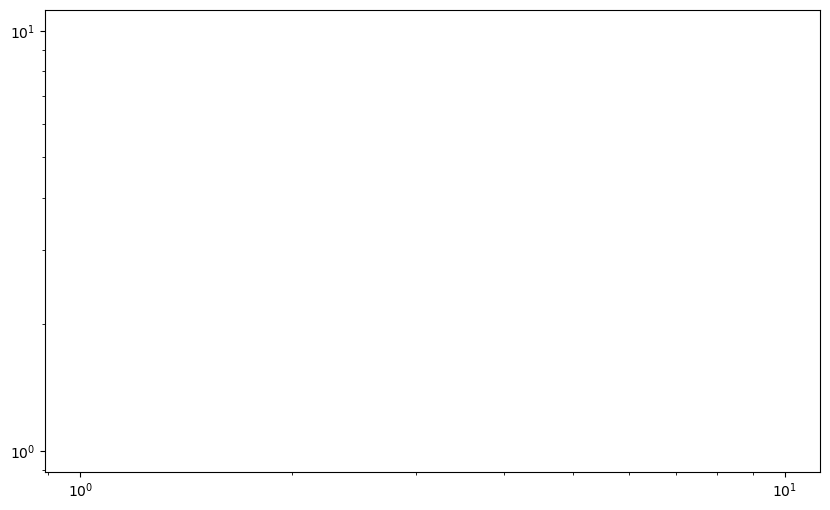

In [4]:
from feedbax.plot import plot_loss_history

# Losses are stored in `train_history.loss`.
plot_loss_history(train_history)

For the task belonging to this pairing, performance is scored based on four *loss terms*. The model gets a good score on a trial if:

- the *position* of the effector (in this case, the point mass itself) is at the goal position, by the end of the trial;
- the *velocity* of the effector is zero at the end of the reach;
- the *activity* of the units ("neurons") in the neural network is small;
- the *outputs* of the neural network—in this case, the forces applied to the point mass—are small.

A weighted sum of these terms gives the total loss—the smaller the total, the better the performance. Note that these four terms are not the only ones we could choose. Depending on the context we could add or remove certain terms, or change the weighting on each term based on how important we think it should be to the task at hand. 

By "training the model", we mean altering some part of it—in this case, the strengths of the connections in the neural network—so that its behaviour changes, and it gets a better total score on each batch of trials. In this example, the technical details of training are taken care of entirely in the background.

Looking at the loss plot above, it's clear that the first term (effector position) dominates the total score for most of the run. This makes sense for a *reaching task* like `SimpleReaches`, since the main thing we're concerned about is that our neural network should learn to move the point mass to the goal position. And it certainly seems like it's learning: over the training history there's a large and consistent decrease in the loss.

<!-- TODO: the velocity term is also important though, and the main difference between it and the position term in terms of magnitude is... -->

## Evaluating the trained model

Let's check whether the network actually learned to push the point mass to the goal. 

Like all Feedbax tasks, `SimpleReaches` also provides set of trials for the purpose of *validation*. Now we evaluate the model on this set of trials:

In [5]:
task = context.task  # Shorthand, since we'll be referring to this more than once

states = task.eval(model, key=jr.PRNGKey(2))

and plot the resulting states of the model over time:

(<Figure size 1200x600 with 3 Axes>,
 array([<Axes: title={'center': 'Position'}, xlabel='$x$', ylabel='$y$'>,
        <Axes: title={'center': 'Velocity'}, xlabel='$\\dot x$', ylabel='$\\dot y$'>,
        <Axes: title={'center': 'Control force'}, xlabel='$\\mathrm{f}_x$', ylabel='$\\mathrm{f}_y$'>],
       dtype=object))

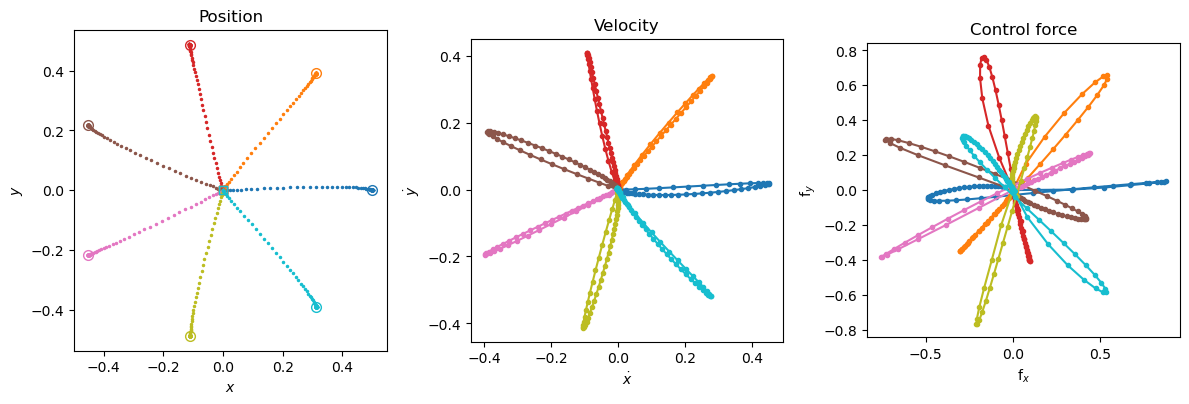

In [6]:
from feedbax.plot import plot_reach_trajectories

# Use `trial_specs=task.validation_trials` to draw little circles at 
# the goal positions specified by the task. Not strictly necessary.
plot_reach_trajectories(states, trial_specs=task.validation_trials)

Each color is a different trial in the validation set, which consists of center-out reaches. The starting position is `(0, 0)` for all seven reaches.

Clearly, the network has learned to move the point mass to the goal. It's also learned to slow down and stop there: the velocities return to zero. 

Is this an improvement over the untrained model? Since `context.model` still refers to the untrained model, we can evaluate it just like we did for the trained model a moment ago.

(<Figure size 1200x600 with 3 Axes>,
 array([<Axes: title={'center': 'Position'}, xlabel='$x$', ylabel='$y$'>,
        <Axes: title={'center': 'Velocity'}, xlabel='$\\dot x$', ylabel='$\\dot y$'>,
        <Axes: title={'center': 'Control force'}, xlabel='$\\mathrm{f}_x$', ylabel='$\\mathrm{f}_y$'>],
       dtype=object))

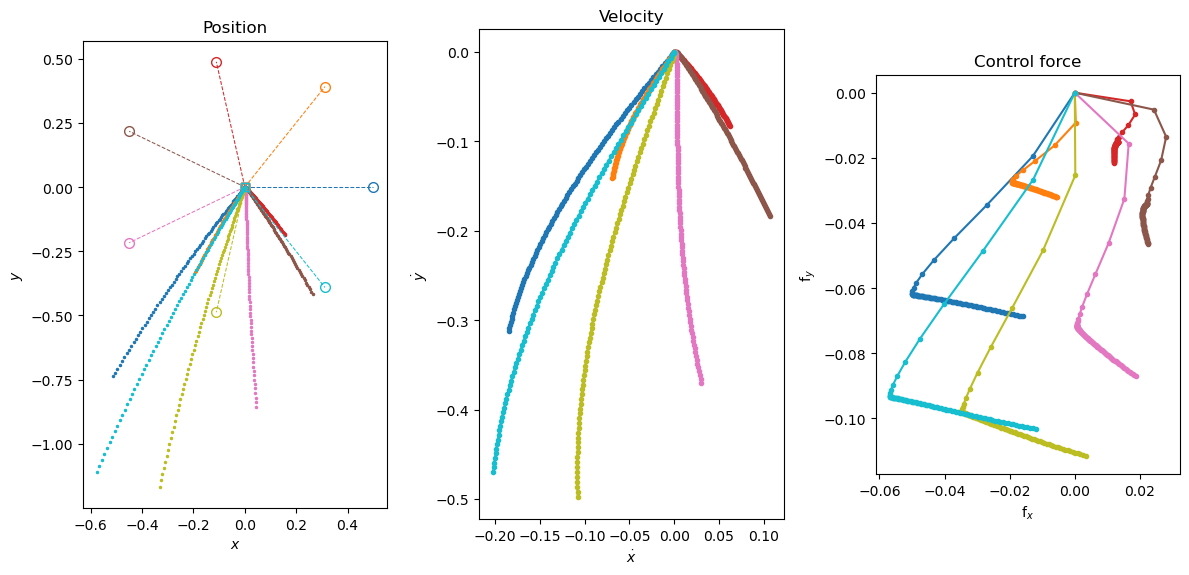

In [7]:
plot_reach_trajectories(
    task.eval(
        context.model, 
        key=jr.PRNGKey(2)
    ), 
    trial_specs=task.validation_trials,
    # Draw ideal straight paths as dashed lines, based on `trial_specs`.
    straight_guides=True,  
)

Obviously, our model could not complete the task before we had trained it to do so!

## Training multiple models simultaneously

TODO: How to do automatic model ensembling with any pre-built model. 

## Looking into the network

Evaluate a single model from the ensemble, then use `plot_activity_heatmap`, `plot_activity_sample_units` on it